In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
# x=os.listdir('../input')   

In [19]:
datagen = ImageDataGenerator(rescale=1./255,
                                      zoom_range=0.2,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      validation_split=0.2
                       )
train_data = datagen.flow_from_directory('/kaggle/input/aptos-augmented-images/aptos-augmented-images/aptos-augmented-images',
                                                     target_size=(224,224),
                                                     batch_size=64,
                                                     class_mode = 'categorical',
                                                     subset = 'training')

valid_data = datagen.flow_from_directory('/kaggle/input/aptos-augmented-images/aptos-augmented-images/aptos-augmented-images',
                                                     target_size=(224,224),
                                                     batch_size=64,
                                                     class_mode = 'categorical',
                                                     subset = 'validation')

Found 8000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.


In [20]:
!pip install -q efficientnet

In [21]:
import efficientnet.tfkeras as efn

In [22]:
def lr_rate(epoch,lr):
    if epoch<10:
        lr=0.0001
        return lr
    elif epoch<=15:
        lr=0.0005
        return lr
    elif epoch<=30:
        lr=0.0001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr
lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [23]:
model = tf.keras.Sequential([
        efn.EfficientNetB0(
            input_shape=(224,224, 3),
            weights='imagenet',
            include_top=False
        ),tf.keras.layers.Flatten(),tf.keras.layers.Dense(5, activation='softmax')
    ])
    
model.compile(optimizer="Adam",loss='categorical_crossentropy',metrics=['acc'])


In [ ]:
history = model.fit_generator(generator=train_data, validation_data=valid_data, callbacks=[lr_callback], epochs=40, verbose=1)

/tmp/ipykernel_29/1526569464.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_data, validation_data=valid_data, callbacks=[lr_callback], epochs=40, verbose=1)


Epoch 1/40


2023-06-18 21:42:05.178146: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 269s 1s/step - loss: 1.2461 - acc: 0.5264 - val_loss: 1.3725 - val_acc: 0.4720 - lr: 1.0000e-04
Epoch 2/40
125/125 [==============================] - 172s 1s/step - loss: 0.9106 - acc: 0.6375 - val_loss: 1.1609 - val_acc: 0.5730 - lr: 1.0000e-04
Epoch 3/40
125/125 [==============================] - 171s 1s/step - loss: 0.7674 - acc: 0.6913 - val_loss: 0.9156 - val_acc: 0.6315 - lr: 1.0000e-04
Epoch 4/40
125/125 [==============================] - 172s 1s/step - loss: 0.6908 - acc: 0.7205 - val_loss: 0.7955 - val_acc: 0.6905 - lr: 1.0000e-04
Epoch 5/40
 50/125 [===========>..................] - ETA: 1:23 - loss: 0.6350 - acc: 0.7569

In [6]:
import matplotlib.pyplot as plt

In [ ]:
def display_training_curves(training, validation, title, subplot):
    
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [ ]:
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss', 211)
display_training_curves(
    history.history['acc'], 
    history.history['val_acc'], 
    'accuracy', 212)

In [ ]:
# save the trained model to use
model.save('/kaggle/working/models__DR.h5')

In [5]:
# get class names associated with dataset images
categories = [ 'No_DR','Mild', 'Moderate', 'Severe', 'Proliferate_DR']
print(categories)

['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']


In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as plt
class FixedDropout(keras.layers.Dropout):
    def call(self, inputs, training=None):
        if training is None:
            training = keras.backend.learning_phase()
        return super().call(inputs, training)

# Register the custom layer or function
keras.utils.get_custom_objects().update({'FixedDropout': FixedDropout})
model = keras.models.load_model('models__DR (4).h5')


In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64
def pred_dr(image_path):

    model = tf.keras.models.load_model('models__DR (4).h5')

    # Testing the model using sample image
    
    image = tf.keras.preprocessing.image.load_img(image_path)
    image = image.resize((224,224))
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = image_array / 255.0
    scaled_img = np.expand_dims(image_array, axis=0)
   

    # Use model to predict the sample image
    pred = model.predict(scaled_img)

    # show the output of predicted image
    output = categories[np.argmax(pred)]
    plt.figure(figsize=(8, 6))
    plt.bar(categories, pred[0])
    plt.title("Diagnosis Prediction")
    plt.xlabel("Diagnosis")
    plt.ylabel("Probability")
    plt.show()
    # Save the chart to a buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    plt.show()
  
    print("Predicted case ->", output)

1/1 [==============================] - 3s 3s/step


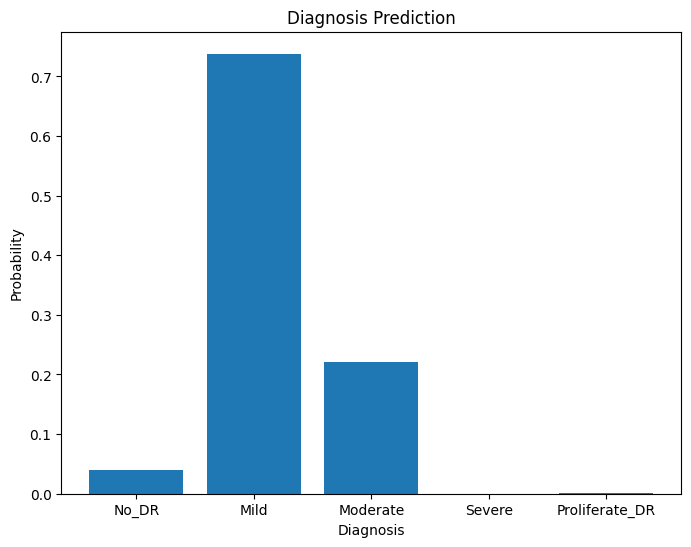

<Figure size 640x480 with 0 Axes>

Predicted case -> Mild


In [20]:
pred_dr('4c60b10a3a6a.png')

1/1 [==============================] - 6s 6s/step


SyntaxError: 'return' outside function (3536301229.py, line 43)

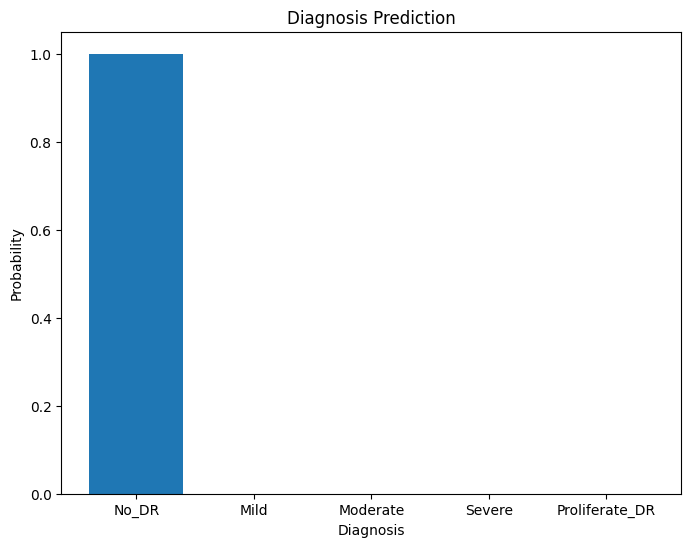

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64
def pred_dr(path):

# Load the model
    model = tf.keras.models.load_model('models__DR (4).h5')

    # Testing the model using sample image
    image_path = "0a85a1e8f9e9.png"
    image = tf.keras.preprocessing.image.load_img(image_path)
    image = image.resize((224, 224))
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = image_array / 255.0
    scaled_img = np.expand_dims(image_array, axis=0)

    # Use model to predict the sample image
    pred = model.predict(scaled_img)

    # Get the output
    output = categories[np.argmax(pred)]

    # Create a bar chart of the predictions
    plt.figure(figsize=(8, 6))
    plt.bar(categories, pred[0])
    plt.title("Diagnosis Prediction")
    plt.xlabel("Diagnosis")
    plt.ylabel("Probability")

    # Save the chart to a buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)

    # Encode the buffer as base64
    image_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')

# Build the HTML to display the chart
